# Modeling

## Imports

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Import from sklearn.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.decomposition import PCA

# Set a random seed.
np.random.seed(42)


matplotlib.style.use('ggplot')

# Let's make some more blobs to test K-Means on
data, color = make_blobs(n_samples=100, random_state=29, centers=3, cluster_std=1.5)


## Importing csv files

In [2]:
df = pd.read_csv('../datasets/clean/games_clean_with_ori.csv')
df.head()

,id,name,popularity,total_rating,Genres,Adventure,Arcade,Fighting,Hack and slash/Beat 'em up,Indie,...,Unity 4,Unity,id Tech 5,Game Modes,Co-operative,Massively Multiplayer Online (MMO),Multiplayer,Other.2,Single player,Split screen
0,118704,TEKKEN 7: Ultimate Edition,1.000000,70.372623,Fighting,0,0,1,0,0,...,0,0,0,Other,0,0,0,0,0,0
1,118916,ACA NEOGEO ART OF FIGHTING 3,1.000000,70.372623,Fighting,0,0,1,0,0,...,0,0,0,Other,0,0,0,0,0,0
2,6273,Red Faction,3.228911,72.050691,Shooter,0,0,0,0,0,...,0,0,0,Other,0,0,0,0,0,0
3,8959,Mutant Mudds Deluxe,1.000000,82.500000,Platform,0,0,0,0,0,...,0,0,0,Single player,0,0,0,0,1,0
4,99735,ACA NEOGEO THE KING OF FIGHTERS '95,1.000000,70.372623,Fighting,0,0,1,0,0,...,0,0,0,Other,0,0,0,0,0,0


In [3]:
#drop categorical columns and assign to new variable
games = df.drop(columns=['id','name','Genres','Game Engines','Game Modes'])

In [4]:
df_no_dum = pd.read_csv('../datasets/clean/games_clean_no_dum.csv')
df_no_dum.head()

,id,name,popularity,total_rating,Genres,Game Engines,Game Modes
0,118704,TEKKEN 7: Ultimate Edition,1.000000,70.372623,Fighting,Other,Other
1,118916,ACA NEOGEO ART OF FIGHTING 3,1.000000,70.372623,Fighting,Other,Other
2,6273,Red Faction,3.228911,72.050691,Shooter,Other,Other
3,8959,Mutant Mudds Deluxe,1.000000,82.500000,Platform,Other,Single player
4,99735,ACA NEOGEO THE KING OF FIGHTERS '95,1.000000,70.372623,Fighting,Other,Other


## PCA

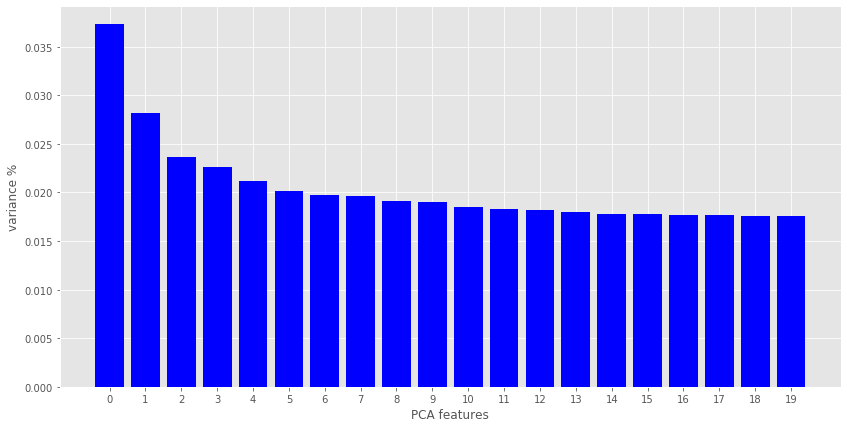

In [5]:
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(games)

# Create a PCA instance: pca
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X_std)

# Plot the explained variances
features = range(pca.n_components_)
plt.figure(figsize = (14,7))
plt.bar(features, pca.explained_variance_ratio_, color='blue')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.savefig('../images/PCA_games.png')
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

## Scatter Plot to find the clusters

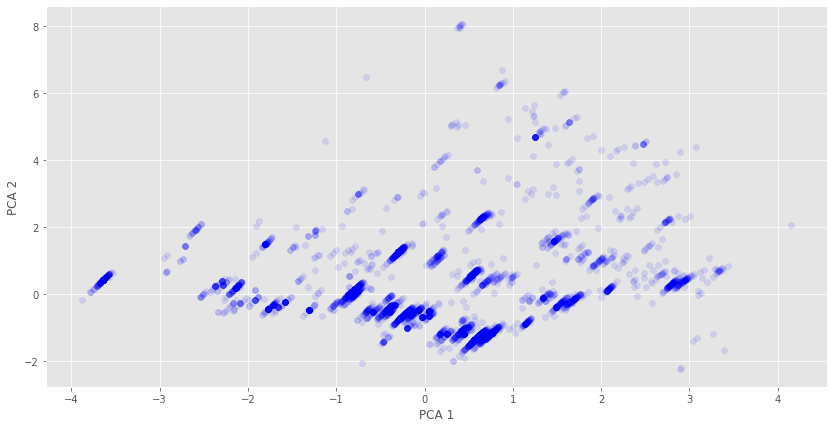

In [6]:
plt.figure(figsize = (14,7))
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='blue')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.savefig('../images/PCA_to_cluster_games.png')

## Find the Clusters

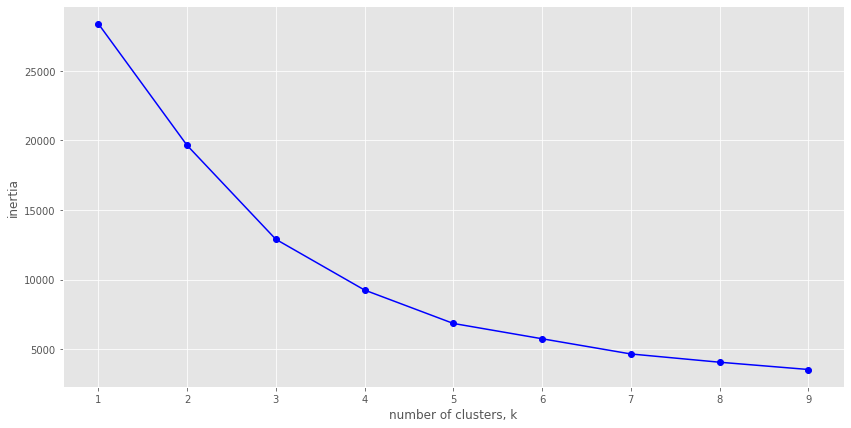

In [7]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.figure(figsize = (14,7))
plt.plot(ks, inertias, '-o', color='blue')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)


plt.savefig('../images/PCA_k_scores_glimpse.png')
plt.show()



## k-Means Clustering

In [8]:
X = PCA_components[0]
y = PCA_components[1]

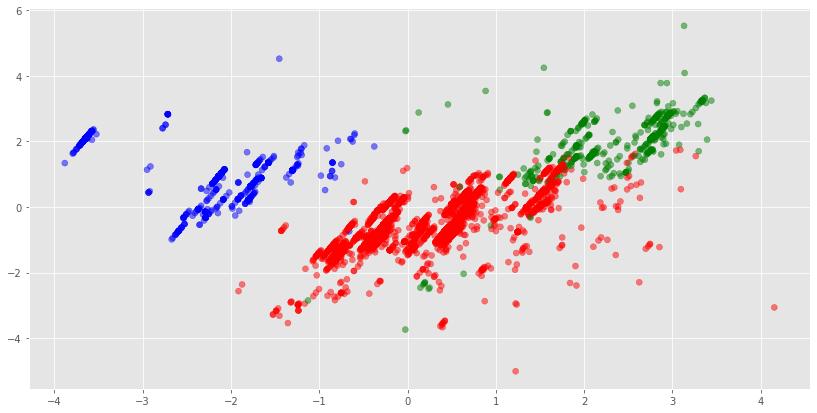

In [9]:
# Set a 3 KMeans clustering
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(principalComponents)

# Define our own color map
LABEL_COLOR_MAP = {0 : 'r',1 : 'g',2 : 'b'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

# Plot the scatter digram
plt.figure(figsize = (14,7))
plt.scatter(principalComponents[:,0],principalComponents[:,2], c= label_color, alpha=0.5) 

plt.savefig('../images/PCA_k_cluster_final.png')

plt.show()

## Metrics: inertia and the silhouette score

In [10]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [11]:
silhouette_score(principalComponents, kmeans.labels_)

0.15325487015169403

In [12]:
scores = []
for k in range(2, 31):
    cl = KMeans(n_clusters=k)
    cl.fit(principalComponents)
    inertia = cl.inertia_
    sil = silhouette_score(principalComponents, cl.labels_)
    scores.append([k, inertia, sil])
    
score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette']

In [13]:
score_df.head()

,k,inertia,silhouette
0,2,121733.054924,0.132087
1,3,115740.841982,0.151838
2,4,110230.722590,0.160775
3,5,107064.622454,0.191152
4,6,102874.222539,0.225464


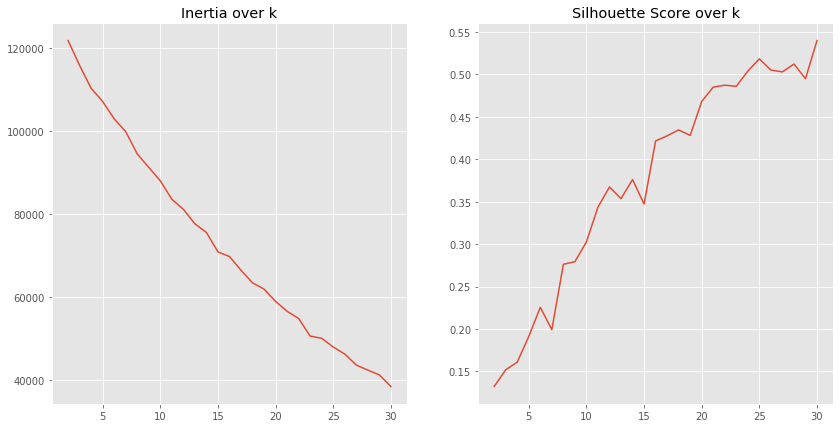

<Figure size 1008x504 with 0 Axes>

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
plt.figure(figsize = (14,7))

axes[0].plot(score_df.k, score_df.inertia)
axes[0].set_title('Inertia over k')
axes[1].plot(score_df.k, score_df.silhouette);
axes[1].set_title('Silhouette Score over k')